In [1]:
#### 

import torch
import sys
sys.path.append("..")
from singleVis.data import NormalDataProvider
REF_PATH = "/home/yifan/dataset/clean/pairflip/cifar10/0"

CLEAN_PATH = "/home/yifan/dataset/clean_ref/pairflip/cifar10/0"
sys.path.append(REF_PATH)


from config import config

SETTING = config["SETTING"]
CLASSES = config["CLASSES"]
DATASET = config["DATASET"]
GPU_ID = config["GPU"]
EPOCH_START = config["EPOCH_START"]
EPOCH_END = config["EPOCH_END"]
EPOCH_PERIOD = config["EPOCH_PERIOD"]

# Training parameter (subject model)
TRAINING_PARAMETER = config["TRAINING"]
NET = TRAINING_PARAMETER["NET"]
LEN = TRAINING_PARAMETER["train_num"]

# Training parameter (visualization model)
VISUALIZATION_PARAMETER = config["VISUALIZATION"]
PREPROCESS = VISUALIZATION_PARAMETER["PREPROCESS"]
LAMBDA = VISUALIZATION_PARAMETER["LAMBDA"]
B_N_EPOCHS = VISUALIZATION_PARAMETER["BOUNDARY"]["B_N_EPOCHS"]
L_BOUND = VISUALIZATION_PARAMETER["BOUNDARY"]["L_BOUND"]
INIT_NUM = VISUALIZATION_PARAMETER["INIT_NUM"]
ALPHA = VISUALIZATION_PARAMETER["ALPHA"]
BETA = VISUALIZATION_PARAMETER["BETA"]
MAX_HAUSDORFF = VISUALIZATION_PARAMETER["MAX_HAUSDORFF"]
# HIDDEN_LAYER = VISUALIZATION_PARAMETER["HIDDEN_LAYER"]
ENCODER_DIMS = VISUALIZATION_PARAMETER["ENCODER_DIMS"]
DECODER_DIMS = VISUALIZATION_PARAMETER["DECODER_DIMS"]
S_N_EPOCHS = VISUALIZATION_PARAMETER["S_N_EPOCHS"]
T_N_EPOCHS = VISUALIZATION_PARAMETER["T_N_EPOCHS"]
N_NEIGHBORS = VISUALIZATION_PARAMETER["N_NEIGHBORS"]
PATIENT = VISUALIZATION_PARAMETER["PATIENT"]
MAX_EPOCH = VISUALIZATION_PARAMETER["MAX_EPOCH"]

VIS_MODEL_NAME = 'vis'
EVALUATION_NAME = VISUALIZATION_PARAMETER["EVALUATION_NAME"]

SEGMENTS = [(EPOCH_START, EPOCH_END)]
# define hyperparameters
DEVICE = torch.device("cuda:{}".format(GPU_ID) if torch.cuda.is_available() else "cpu")

import Model.model as subject_model
net = eval("subject_model.{}()".format(NET))


ref_provider = NormalDataProvider(REF_PATH, net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, split=-1, device=DEVICE, classes=CLASSES,verbose=1)
tar_provider = NormalDataProvider(CLEAN_PATH, net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, split=-1, device=DEVICE, classes=CLASSES,verbose=1)
ref_train_data = ref_provider.train_representation(200).squeeze()
tar_train_data = tar_provider.train_representation(200).squeeze()
ref_prediction = ref_provider.get_pred(200, ref_train_data)
tar_prediction = tar_provider.get_pred(200, tar_train_data)
ref_prediction_res = ref_prediction.argmax(axis=1)
tar_prediction_res = tar_prediction.argmax(axis=1)
### get confidence scores result
from scipy.special import softmax
import numpy as np
def get_conf(pred):
    scores = np.amax(softmax(pred, axis=1), axis=1)
    return scores
ref_scores = get_conf(ref_prediction)
tar_scores =  get_conf(tar_prediction)

import math
distance_high_indicates = []
same_set_indicates = []
def EMAE(Y, y, a=1.5):
    """
    param：
        Y: 原始序列（假定波动较大）
        y: 拟合序列（假定波动较小）
        a: 指数的自变量，≥1，该值越大，则两序列间的残差（特别是残差的离群值）对EMAE返回值影响的强化作用越明显；
        当a=1时，EMAE化简为MAE。
    return：
        指数MAE值，该值的大小与两条序列间平均偏差程度成正比，该值越大，平均偏差程度越大；
        且两序列间的残差（特别是残差的离群值）对EMAE的影响比MAE大。
    """

    Y, y = np.array(Y), np.array(y)
    Y[Y < 0] = 0  # 使指数的底数≥1，则所有指数均为递增函数
    y[y < 0] = 0
    emae = sum(abs((Y+1)**a - (y+1)**a)) / len(Y)

    return emae

for i in range(len(ref_prediction)):
    mes_val = EMAE(ref_prediction[i], tar_prediction[i])
    if mes_val > 30:
        distance_high_indicates.append(i)
    elif mes_val < 0.3:
        same_set_indicates.append(i)
#### 
diff_indicates = []
same_indicates = []
for i in range(len(ref_prediction)):
    # if tar_prediction_res[i] == ref_prediction_res[i] and ref_scores[i] == tar_scores[i] and  (i in same_set_indicates): 
    if tar_prediction_res[i] == ref_prediction_res[i] and math.fabs(ref_scores[i] - tar_scores[i]) < 0.1 and  (i in same_set_indicates):     
        same_indicates.append(i)
    else:
        diff_indicates.append(i)

# need_adjust_indicates = []
# for i in range(len(ref_prediction)):
#     if tar_prediction_res[i] == ref_prediction_res[i] and ref_scores[i] == tar_scores[i] and  (i in same_set_indicates):     
#         same_indicates.append(i)
#     else:
#         diff_indicates.append(i)
pred_diff_list = []
for i in range(len(ref_prediction)):
    # if tar_prediction_res[i] == ref_prediction_res[i] and ref_scores[i] == tar_scores[i] and  (i in same_set_indicates): 
    if tar_prediction_res[i] != ref_prediction_res[i] or math.fabs(ref_scores[i] - tar_scores[i]) > 0.3:     
        pred_diff_list.append(i)
pred_diff_class = []
for i in range(len(ref_prediction)):
    # if tar_prediction_res[i] == ref_prediction_res[i] and ref_scores[i] == tar_scores[i] and  (i in same_set_indicates): 
    if tar_prediction_res[i] != ref_prediction_res[i]:     
        pred_diff_class.append(i)

print('predict diff sample number:',len(pred_diff_list),'absolute align sample number:',len(same_indicates))

diff_combine_same = np.concatenate((same_indicates, pred_diff_list), axis=0)


/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Finish initialization...
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 8820.31it/s]


predict diff sample number: 29 absolute align sample number: 17


In [104]:
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
from alignment.trans_visualizer_border import visualizer
I = np.eye(512)
EPOCH_START = 190
EPOCH_END = 200
EPOCH_PERIOD = 1
TOTOAL_EPOCH = EPOCH_END - EPOCH_START
showList = pred_diff_class

###### REFERENCE
ref_projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
ref_vis = visualizer(ref_provider, I,I, np.dot(ref_provider.train_representation(200),I), ref_projector, 200,[pred_diff_class],'tab10')
ref_embeddings_2d = np.zeros((TOTOAL_EPOCH, len(showList), 2))
for i in range(1, TOTOAL_EPOCH+1, EPOCH_PERIOD):
    ref_embeddings_2d[i-1] = ref_projector.individual_project(200, ref_provider.train_representation(EPOCH_START + i -1)[[showList]])
    # print(embeddings_2d.shape)
ref_embeddings_2d = np.transpose(ref_embeddings_2d, [1,0,2])
###### TARGET
tar_projector = TimeVisProjector(vis_model=model, content_path=CLEAN_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
tar_vis = visualizer(tar_provider, I,I, np.dot(tar_provider.train_representation(200),I), tar_projector, 200,[pred_diff_class],'tab10')
tar_embeddings_2d = np.zeros((TOTOAL_EPOCH, len(showList), 2))
for i in range(1, TOTOAL_EPOCH+1, EPOCH_PERIOD):
    tar_embeddings_2d[i-1] = tar_projector.individual_project(200, tar_provider.train_representation(EPOCH_START + i -1)[[showList]])
    # print(embeddings_2d.shape)
tar_embeddings_2d = np.transpose(tar_embeddings_2d, [1,0,2])

/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  app.launch_new_instance()
/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


(-7.262819051742554, -7.614070177078247, 2.863030433654785, 2.471569776535034)
Computing decision regions ...


100%|██████████| 200/200 [00:00<00:00, 9747.28it/s]


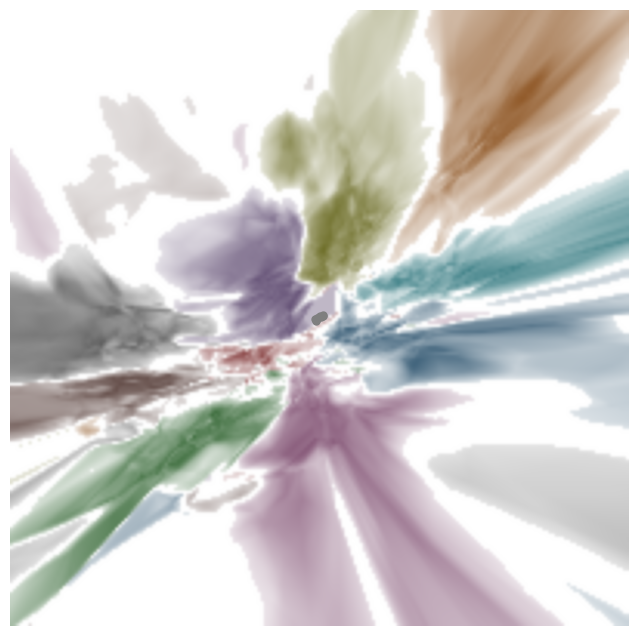

In [110]:
idx = 1
xs = ref_embeddings_2d[:, :, 0]
ys = ref_embeddings_2d[:, :, 1]
# idx = np.random.choice(len(xs), 1)[0]

labels = ref_provider.train_labels(200)
label = labels[same_indicates[idx]]

vx = xs[:, 1:]-xs[:, :-1]
vy = ys[:, 1:]-ys[:, :-1]
x_min = xs.min()
y_min = ys.min()
x_max = xs.max()
y_max = ys.max()

xy_limit = (xs[idx].min()-5, ys[idx].min()-5, xs[idx].max()+5, ys[idx].max()+5)
print(xy_limit)
ref_vis.draw_trajectory(EPOCH_END, xs[idx][:-1], ys[idx][:-1],label = label, xy_limit=xy_limit, path="./vis")

In [106]:

print('current',same_indicates[idx], 'label', labels[same_indicates[idx]], 'ref_res,', ref_prediction_res[same_indicates[idx]], 'tar res', tar_prediction_res[same_indicates[idx]])

current 1256 label 4 ref_res, 4 tar res 4


0
(-2.793041706085205, -3.383203625679016, 7.297200679779053, 6.717050671577454)
Computing decision regions ...


100%|██████████| 200/200 [00:00<00:00, 9672.21it/s]


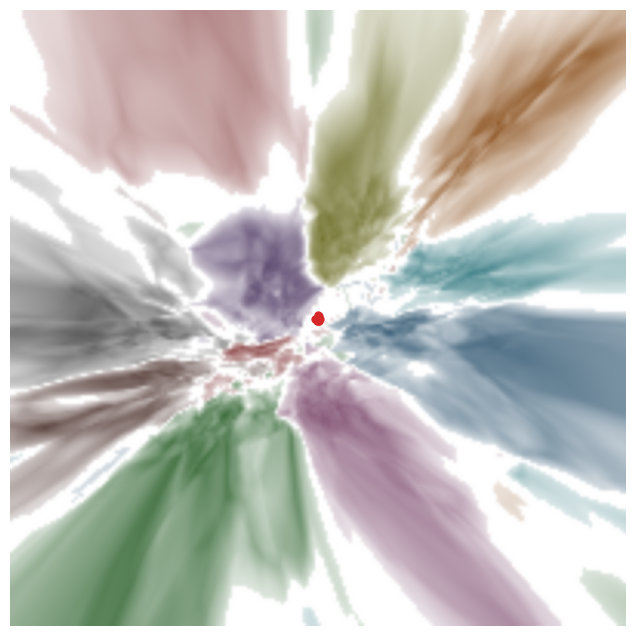

In [107]:

xs = tar_embeddings_2d[:, :, 0]
ys = tar_embeddings_2d[:, :, 1]
# idx = np.random.choice(len(xs), 1)[0]
# idx = 2
# idx = len(xs) - 1
print(idx)

labels = tar_provider.train_labels(200)
# labels[pred_diff_class[idx]]
# print(labels[pred_diff_class[idx]])
label = labels[same_indicates[idx]]

vx = xs[:, 1:]-xs[:, :-1]
vy = ys[:, 1:]-ys[:, :-1]
x_min = xs.min()
y_min = ys.min()
x_max = xs.max()
y_max = ys.max()

xy_limit = (xs[idx].min()-5, ys[idx].min()-5, xs[idx].max()+5, ys[idx].max()+5)
print(xy_limit)
tar_vis.draw_trajectory(EPOCH_END, xs[idx][:-1], ys[idx][:-1], label=label, xy_limit=xy_limit, path="./vis")